In [30]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate, integrate, optimize, spatial
import plotly as py
import plotly.graph_objs as go
from simanneal import Annealer
from enum import Enum
from shapely.geometry import Polygon
from scipy.spatial import Voronoi
from numpy import dot,array,empty_like
from matplotlib.path import Path
from shapely.geometry import LineString, LinearRing
from shapely.geometry.point import Point
from shapely.geometry.multipoint import MultiPoint


py.offline.init_notebook_mode(connected = True)

In [3]:
# Read coordinates of characters from txt

char_pos_dict = {}

with open("voronoi_keyboard_data.txt", 'r') as f:
    for line in f:
        pos_x, pos_y, char = line.split()
        char_pos_dict[char] = np.array([float(pos_x), float(pos_y)])
        
    print(char_pos_dict)

{'v': array([945.9147, 124.1636]), 'q': array([ 92.13049, 625.249  ]), 'e': array([468.5197, 627.118 ]), 'd': array([545.4163, 366.1996]), 'f': array([761.9483, 375.7397]), 'i': array([1454.123 ,  626.6086]), 'w': array([277.6977, 635.4782]), 'j': array([1383.618 ,  368.6852]), 'p': array([1828.139 ,  606.5282]), 'r': array([663.2721, 633.5171]), 'h': array([1171.386 ,  378.1138]), 'u': array([1257.24  ,  635.1962]), 's': array([320.3738, 366.9692]), 'g': array([968.453 , 377.3322]), 'y': array([1058.733 ,  634.6003]), 'b': array([1204.858 ,  123.4691]), 't': array([861.2269, 635.0624]), 'z': array([145.3186, 116.0125]), 'm': array([1474.588 ,  121.9476]), 'k': array([1611.087 ,  373.1093]), 'a': array([103.7216, 360.1618]), 'o': array([1646.82  ,  647.0535]), 'l': array([1822.402 ,  330.0949]), 'c': array([689.5285, 122.352 ]), 'n': array([1760.41  ,  106.5383]), 'x': array([424.4543, 119.8046])}


In [4]:
class Sections(Enum):
    LEFT = 0
    RIGHT = 1
    MIDDLE = 2

Characters to sections: defaultdict(<class 'int'>, {'a': <Sections.LEFT: 0>, 'b': <Sections.RIGHT: 1>, 'c': <Sections.LEFT: 0>, 'd': <Sections.LEFT: 0>, 'e': <Sections.LEFT: 0>, 'f': <Sections.LEFT: 0>, 'g': <Sections.MIDDLE: 2>, 'h': <Sections.RIGHT: 1>, 'i': <Sections.RIGHT: 1>, 'j': <Sections.RIGHT: 1>, 'k': <Sections.RIGHT: 1>, 'l': <Sections.RIGHT: 1>, 'm': <Sections.RIGHT: 1>, 'n': <Sections.RIGHT: 1>, 'o': <Sections.RIGHT: 1>, 'p': <Sections.RIGHT: 1>, 'q': <Sections.LEFT: 0>, 'r': <Sections.LEFT: 0>, 's': <Sections.LEFT: 0>, 't': <Sections.LEFT: 0>, 'u': <Sections.RIGHT: 1>, 'v': <Sections.MIDDLE: 2>, 'w': <Sections.LEFT: 0>, 'x': <Sections.LEFT: 0>, 'y': <Sections.RIGHT: 1>, 'z': <Sections.LEFT: 0>})
Initial thumb positions: [[ 446.13402417  415.30534167]
 [1472.78366667  412.66208333]]


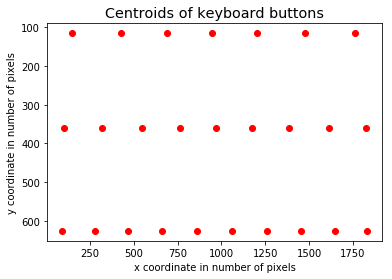

In [5]:
# Divide into left, right and middle sections of keyboard

left_keys = set(list("qwertasdfzxc"))
right_keys = set(list("yuiophjklbnm"))
middle_keys = set(list("gv"))

keyboard_sections = [left_keys, right_keys, middle_keys]

char_section_dict = collections.defaultdict(int)
for char_ascii in range(26):
    char = chr(ord("a") + char_ascii)
    for ind, section in enumerate(keyboard_sections):
        if char in section:
            char_section_dict[char] = Sections(ind)
            break
print("Characters to sections: {}".format(char_section_dict))

# Initialize left thumb and right thumb positions
left_mean = np.mean(np.array([char_pos_dict[char] for char in left_keys]), axis = 0)
right_mean =  np.mean(np.array([char_pos_dict[char] for char in right_keys]), axis = 0)

thumbs_pos = np.array([left_mean, right_mean])
print("Initial thumb positions: {}". format(thumbs_pos))

for char in "qwertyuiop":
    char_pos_dict[char][1] = char_pos_dict["q"][1]
    plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], "ro")


for char in "asdfghjkl":
    char_pos_dict[char][1] = char_pos_dict["a"][1]
    plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], "ro")

for char in "zxcvbnm":
    char_pos_dict[char][1] = char_pos_dict["z"][1]
    plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], "ro")
    
plt.rc('font', size=12)  
plt.title("Centroids of keyboard buttons")
plt.xlabel("x coordinate in number of pixels")
plt.ylabel("y coordinate in number of pixels")
#for pos_x, pos_y in thumbs_pos:
#    plt.plot(pos_x, pos_y, "bo")

#plt.plot([0,0,1920,1920],[0,1080,0,1080], "go")    
plt.gca().invert_yaxis()

In [8]:
# Read passages from txt and remove non-alphabetical characters
cleaned_passage = []
with open("pride_and_prejudice.txt", 'r') as f:
    for line in f:
        for char in line:
            if char.isalpha():
                if ord(char) - ord('a') >=0 and ord(char) - ord('a') <26:
                    cleaned_passage.append(char.lower())

In [9]:
# Assume first order relations between buttons and type with only one hand
first_order_count = np.array([[0 for i in range(26)] for j in range(26)])

for ind in range(len(cleaned_passage) - 1):
    first_order_count[ord(cleaned_passage[ind]) - ord('a')][ord(cleaned_passage[ind+1]) - ord('a')] += 1

total_dist = 0

for i in range(26):
    for j in range(26):
        pos1, pos2 = char_pos_dict[chr(i + ord('a'))], char_pos_dict[chr(j + ord('a'))]
        total_dist += np.linalg.norm(pos1 - pos2) * first_order_count[i][j]
        
print("Total distance when typing with one hand: {}".format(total_dist))
    

Total distance when typing with one hand: 9636165.409677958


# Optimal 3D shape for a keyboard

Assumptions:

1. Symmetric
2. Zero gradient on the sides
3. Smooth function
4. One hand responsible for one side of the keyboard

Objective functions:

1. 1D Fitts law (time)
2. Distance (attempted but failed)

Parameters:
1. Control points of a spline

Constraints:
1. Keyboard area normalised


# Objective function: distance

Calculated curve_length: 1118.5012650346928
Numerical error: 9.192484374166139e-06
Scaled length:(960.0, 7.889830145709649e-06)


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

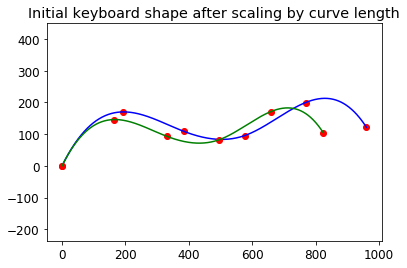

In [7]:
# Decide number of control points to define the curve (probably 1D curve first)
dof = 5
max_height = 200
# Since the keyboard is symmetric, we only need to define half of the keyboard.
inpl_h, inpl_w = 1080*3/4, 1920/2
# Use B-spline to fit the points (to get a smooth surface)
inpl_x = np.array(list(range(0, dof + 1))) / dof * inpl_w
inpl_y = np.random.rand(dof + 1) * max_height
inpl_y[0] = 0

# Interpolate with B-spline
tck = interpolate.splrep(inpl_x, inpl_y, s = 0)
xnew = np.linspace(0, inpl_w, int(inpl_w) * 3)
ynew = interpolate.splev(xnew, tck, der = 0)

plt.plot(inpl_x, inpl_y, 'ro', xnew, ynew, 'b') 
plt.axis('equal')
plt.title("Initial keyboard shape without scaling")
# Find length of spline by numerical integration
# Normalize movement in x direction by curve length to ensure the final lengh
length_integral = lambda x, func: np.sqrt(1 + interpolate.splev(x, func, der = 1) ** 2)
curve_integral = lambda x: length_integral(x, tck)
find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
total_curve_length, error = find_curve_length(inpl_w)
print("Calculated curve_length: {}".format(total_curve_length))
print("Numerical error: {}".format(error))

scale_factor = inpl_w/total_curve_length
scaled_spline = interpolate.splrep(inpl_x * scale_factor, inpl_y * scale_factor, s = 0)
scaled_xnew = xnew * scale_factor
scaled_ynew = interpolate.splev(scaled_xnew, scaled_spline, der = 0)
scaled_curve_integral  = lambda x: length_integral(x, scaled_spline)
scaled_curve_length = lambda x: scipy.integrate.quad(scaled_curve_integral, 0, x)
print("Scaled length:{}".format(scaled_curve_length(inpl_w * scale_factor)))
plt.plot(inpl_x * scale_factor, inpl_y * scale_factor, 'ro', scaled_xnew, scaled_ynew, 'g-')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

# Option 1. constraint the total length to be 1920 or Option 2 only constrain the coordinates of points
# project points back onto the curve
# for option 1. project onto curve using length
# optimize the height of the points to reduce the movement of the thumbs

In [8]:
def plotMeshShape(x,spline, plot_points = False, points = None):
    y = np.linspace(0, inpl_h,3)
    X, Y = np.meshgrid(x,y)
    Z = interpolate.splev(X, spline, der = 0)
    data = [go.Mesh3d(x = X.flatten(), y= Y.flatten(), z= Z.flatten())]
    layout = go.Layout(
             scene=dict(
                 aspectmode='data'))
    fig = go.Figure(data = data, layout = layout)

    if plot_points:
        extra_points = go.Scatter3d(x = points[:,0], 
                                    y = points[:,1], 
                                    z = points[:,2], 
                                    mode = 'markers',
                                    marker=dict(
                                        size=12,
                                        #color=z,                # set color to an array/list of desired values
                                        #colorscale='Viridis',   # choose a colorscale
                                        opacity=0.8
                                    ))
        fig = go.Figure(data + [extra_points], layout = layout)
    
    py.offline.iplot(fig)
    
plotMeshShape(scaled_xnew ,scaled_spline, True, np.array([[1200,1,2]]))

In [9]:
# Assume the new keyboard is formed by folding the keyboard onto the curved surface

new_locations = []
curved_char_pos_dict = {}
for key in left_keys:
    flat_x, flat_y = char_pos_dict[key]
    pos_x_on_curved_keyboard = optimize.brentq(lambda x: scaled_curve_length(x)[0] - flat_x, 0, inpl_w)
    
    new_location = np.array([pos_x_on_curved_keyboard, flat_y, interpolate.splev(pos_x_on_curved_keyboard, scaled_spline, der = 0) ])
    new_locations.append(new_location)
    print("Key: {}\tCurved x: {}".format(key, pos_x_on_curved_keyboard))
    curved_char_pos_dict[key] = new_location
    
plotMeshShape(scaled_xnew ,scaled_spline, True, np.array(new_locations))
    
    

Key: e	Curved x: 404.3763677666662
Key: q	Curved x: 49.8823783318052
Key: d	Curved x: 491.7760764341422
Key: x	Curved x: 497.61042976075896
Key: w	Curved x: 207.5449326531497
Key: a	Curved x: 105.80195742858736
Key: f	Curved x: 663.5694351777341
Key: s	Curved x: 302.1807561582736
Key: z	Curved x: 293.67338458574045
Key: r	Curved x: 579.3766533053667
Key: t	Curved x: 744.2430319120524
Key: c	Curved x: 658.1609704665584


In [10]:
# Only consider letters typed by left hand

left_thumb_movement_dict = collections.defaultdict(int)

prev_char = None
for char in cleaned_passage:
    if char in left_keys:
        if prev_char == None:
            prev_char = char

        else:
            left_thumb_movement_dict[(prev_char, char)] += 1
            prev_char = char
            
for key, value in left_thumb_movement_dict.items():
    print("{}\t{}".format(key, value))

('t', 's')	103
('s', 'a')	139
('a', 't')	228
('t', 'r')	73
('r', 't')	123
('t', 'e')	464
('e', 'r')	308
('r', 's')	117
('a', 'a')	54
('a', 'c')	69
('c', 'w')	7
('w', 'e')	71
('e', 'd')	215
('d', 'e')	160
('d', 't')	118
('t', 'a')	211
('a', 's')	183
('s', 'e')	230
('e', 'a')	263
('s', 's')	112
('e', 's')	203
('s', 'f')	44
('f', 'a')	35
('a', 'd')	214
('d', 'f')	22
('f', 'r')	94
('s', 't')	183
('e', 'w')	104
('w', 'a')	102
('t', 'f')	54
('a', 'w')	22
('w', 'f')	13
('f', 'e')	68
('e', 'e')	223
('t', 't')	140
('w', 't')	64
('e', 'f')	93
('s', 'r')	42
('r', 'e')	283
('w', 's')	24
('f', 's')	18
('s', 'c')	46
('c', 'a')	70
('a', 'e')	137
('e', 't')	239
('r', 'a')	78
('r', 'd')	59
('s', 'w')	31
('f', 'x')	1
('x', 'e')	6
('d', 's')	80
('f', 't')	44
('r', 'r')	46
('c', 's')	23
('s', 'd')	31
('r', 'f')	27
('d', 'a')	128
('a', 'r')	154
('t', 'd')	34
('t', 'w')	84
('w', 'w')	12
('t', 'c')	30
('c', 'r')	26
('e', 'c')	63
('c', 't')	41
('w', 'd')	24
('w', 'r')	8
('a', 'f')	32
('d', 'w')	34
('c', 'e')	

In [178]:
# Define optimization problem to be solved

class OptimizedKeyboardProblem(Annealer):
    
    def move(self):
        movement = np.random.randint(-1,1,len(self.state))
        movement[0] = 0
        self.state = self.state + movement
        #print("State: {}".format(self.state))
        
    def energy(self):
        
        penalty = 0
        if len([num for num in self.state if num < 0])!=0:
            penalty += 100000
        
        for ind, num in enumerate(self.state[:-1]):
            if self.state[ind + 1] < num:
                penalty += 1000 * abs(self.state[ind + 1] - num)
            
        
        spline = self.formScaledSplineFromControlPoints(self.state)
        curved_pos_char_dict = self.flatToCurved(spline)
        total_dist = self.calculateMovement(curved_pos_char_dict)
        
        #print("Spline: {}".format(spline))
        #print("New loc: {}".format(curved_pos_char_dict["d"]))
        #print("Distance: {}".format(total_dist))
        return total_dist + penalty
    
    def findFunctionCurveLength(self,x, func):
        curve_integral = lambda x: np.sqrt(1 + interpolate.splev(x, func, der = 1) ** 2)
        find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
        return find_curve_length(x)
    
    def formScaledSplineFromControlPoints(self,cp):
        # Interpolate with B-spline
        #print("CP: {}".format(cp))
        tck = interpolate.splrep(inpl_x, cp, s = 0)
        total_curve_length, error = self.findFunctionCurveLength(inpl_w, tck)

        scale_factor = inpl_w/total_curve_length
        scaled_spline = interpolate.splrep(inpl_x * scale_factor, cp * scale_factor, s = 0)
        
        return scaled_spline
        
    def flatToCurved(self, spline):
        curved_char_pos_dict = {}
        for key in left_keys:
            flat_x, flat_y = char_pos_dict[key]
            pos_x_on_curved_keyboard = optimize.brentq(lambda x: self.findFunctionCurveLength(x, spline)[0] - flat_x, 0, inpl_w)

            new_location = np.array([pos_x_on_curved_keyboard, flat_y, interpolate.splev(pos_x_on_curved_keyboard, spline, der = 0) ])
            curved_char_pos_dict[key] = new_location
        
        return curved_char_pos_dict
            
    def calculateMovement(self, curved_pos_char_dict):
        dist = 0
        for (char1, char2), count in left_thumb_movement_dict.items():
            pos1, pos2 = curved_pos_char_dict[char1], curved_pos_char_dict[char2]
            dist += np.linalg.norm(pos1 - pos2) * count
        return dist
        
        

In [44]:
initial_state = inpl_y
optimizer = OptimizedKeyboardProblem(initial_state)
optimizer.updates = 1000
optimizer.steps = 3000
optimizer.Tmax = 10000
optimizer.Tmin = 10
optimizer.copy_strategy = "slice"

In [38]:
# 2 Jan 2019 5 dof

state, dist = optimizer.anneal()

Temperature: 7000	Error: 2576658.6493678237	Acceptance:None
Temperature: 6954.29231846979	Error: 2577198.4627898405	Acceptance:1.0
Temperature: 6908.883092961133	Error: 2576708.2337062233	Acceptance:1.0
Temperature: 6863.770374655059	Error: 2575955.5006105285	Acceptance:1.0
Temperature: 6818.952227457741	Error: 2575857.395693016	Acceptance:1.0
Temperature: 6774.426727917405	Error: 2576866.5601438247	Acceptance:1.0
Temperature: 6730.191965141778	Error: 2577380.492323576	Acceptance:1.0
Temperature: 6686.246040716081	Error: 2578140.3693403625	Acceptance:1.0
Temperature: 6642.587068621556	Error: 2577247.734749091	Acceptance:1.0
Temperature: 6599.213175154521	Error: 2577481.7098833127	Acceptance:1.0
Temperature: 6556.12249884596	Error: 2578772.3959962167	Acceptance:1.0
Temperature: 6513.313190381632	Error: 2580663.125367707	Acceptance:1.0
Temperature: 6470.783412522706	Error: 2582971.9482835555	Acceptance:1.0
Temperature: 6428.531340026912	Error: 2583219.1274673366	Acceptance:1.0
Temperatur

Temperature: 3295.4275295047437	Error: 2495977.633629047	Acceptance:1.0
Temperature: 3273.909479215531	Error: 2494621.3238131846	Acceptance:1.0
Temperature: 3252.531934667714	Error: 2493027.2105083438	Acceptance:1.0
Temperature: 3231.2939784053387	Error: 2491517.9458128475	Acceptance:1.0
Temperature: 3210.1946989631333	Error: 2489030.578086074	Acceptance:1.0
Temperature: 3189.233190827394	Error: 2487118.4784799195	Acceptance:1.0
Temperature: 3168.408554397121	Error: 2485520.810673949	Acceptance:1.0
Temperature: 3147.71989594541	Error: 2484550.159424727	Acceptance:1.0
Temperature: 3127.166327581099	Error: 2482869.3538426924	Acceptance:1.0
Temperature: 3106.74696721066	Error: 2481917.878582052	Acceptance:0.8
Temperature: 3086.460938500344	Error: 2480375.1185302646	Acceptance:1.0
Temperature: 3066.3073708385714	Error: 2478911.7320919293	Acceptance:1.0
Temperature: 3046.2853992985683	Error: 2477604.086744056	Acceptance:1.0
Temperature: 3026.3941646012445	Error: 2476920.5840204246	Acceptanc

Temperature: 1561.602835327365	Error: 2590921.387514903	Acceptance:0.9
Temperature: 1551.4060860311054	Error: 2591705.861632175	Acceptance:0.8
Temperature: 1541.2759181304857	Error: 2592755.0955811017	Acceptance:0.7
Temperature: 1531.2118968710442	Error: 2592004.889287769	Acceptance:0.7
Temperature: 1521.2135903371227	Error: 2591150.9056009315	Acceptance:0.8
Temperature: 1511.2805694333288	Error: 2591053.2685183682	Acceptance:0.8
Temperature: 1501.4124078661214	Error: 2594201.9169512647	Acceptance:0.9
Temperature: 1491.6086821255142	Error: 2595577.308056485	Acceptance:0.9
Temperature: 1481.8689714669015	Error: 2595696.1315871705	Acceptance:0.6
Temperature: 1472.1928578930003	Error: 2596867.4882941935	Acceptance:1.0
Temperature: 1462.5799261359114	Error: 2599259.280565306	Acceptance:1.0
Temperature: 1453.0297636392975	Error: 2600672.169827022	Acceptance:0.6
Temperature: 1443.5419605406773	Error: 2599702.316509193	Acceptance:0.8
Temperature: 1434.116109653836	Error: 2600862.3481487175	Ac

Temperature: 735.1641390986372	Error: 2746981.37888927	Acceptance:0.7
Temperature: 730.3637607640158	Error: 2749472.8974853833	Acceptance:0.6
Temperature: 725.5947273099861	Error: 2750502.354173817	Acceptance:0.5
Temperature: 720.8568340648596	Error: 2754073.374438369	Acceptance:0.9
Temperature: 716.1498776933864	Error: 2755251.4018349745	Acceptance:0.7
Temperature: 711.4736561880281	Error: 2757814.5299816527	Acceptance:0.8
Temperature: 706.8279688602889	Error: 2758816.020093593	Acceptance:0.4
Temperature: 702.2126163321012	Error: 2760663.897949058	Acceptance:0.5
Temperature: 697.6274005272725	Error: 2762514.6917218072	Acceptance:0.8
Temperature: 693.0721246629798	Error: 2763849.715634517	Acceptance:0.7
Temperature: 688.5465932413281	Error: 2765189.1180015346	Acceptance:0.7
Temperature: 684.0506120409586	Error: 2765533.659267884	Acceptance:0.5
Temperature: 679.5839881087142	Error: 2767170.3239497053	Acceptance:0.5
Temperature: 675.1465297513565	Error: 2768005.7168154186	Acceptance:0.4


Temperature: 346.097163241472	Error: 2906651.6407919936	Acceptance:0.5
Temperature: 343.8372633963362	Error: 2906735.7283881116	Acceptance:0.1
Temperature: 341.5921199486878	Error: 2907349.5899630594	Acceptance:0.5
Temperature: 339.36163654413883	Error: 2908743.293138548	Acceptance:0.4
Temperature: 337.1457174574631	Error: 2909307.271192597	Acceptance:0.2
Temperature: 334.9442675884888	Error: 2910310.435270546	Acceptance:0.4
Temperature: 332.7571924580168	Error: 2911779.1491406634	Acceptance:0.6
Temperature: 330.5843982037656	Error: 2911877.443068357	Acceptance:0.1
Temperature: 328.4257915763436	Error: 2913800.150447275	Acceptance:0.6
Temperature: 326.28127993524663	Error: 2914245.309855638	Acceptance:0.3
Temperature: 324.15077124488255	Error: 2915003.415527451	Acceptance:0.3
Temperature: 322.0341740706207	Error: 2915284.9874339695	Acceptance:0.2
Temperature: 319.93139757486864	Error: 2916056.6599978264	Acceptance:0.5
Temperature: 317.8423515131733	Error: 2918086.0065651406	Acceptance:

Temperature: 164.00491486391908	Error: 2979398.2266849056	Acceptance:0.1
Temperature: 162.93401708992056	Error: 2980820.422505424	Acceptance:0.5
Temperature: 161.87011192369428	Error: 2980830.109962224	Acceptance:0.1
Temperature: 160.81315370582752	Error: 2980830.109962224	Acceptance:0.2
Temperature: 159.76309707504828	Error: 2981762.950931515	Acceptance:0.5
Temperature: 158.71989696627872	Error: 2981851.774226215	Acceptance:0.1
Temperature: 157.68350860870137	Error: 2982431.607522997	Acceptance:0.3
Temperature: 156.65388752383663	Error: 2982736.882692119	Acceptance:0.4
Temperature: 155.6309895236355	Error: 2983428.2083096546	Acceptance:0.2
Temperature: 154.61477070858146	Error: 2983505.2123052264	Acceptance:0.1
Temperature: 153.60518746580797	Error: 2984212.6058957665	Acceptance:0.2
Temperature: 152.60219646722584	Error: 2984377.5661873054	Acceptance:0.1
Temperature: 151.60575466766377	Error: 2985851.814328277	Acceptance:0.4
Temperature: 150.61581930302128	Error: 2985851.814328277	Acc

Temperature: 77.71693893010865	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 77.20947305952005	Error: 3000635.0948386258	Acceptance:0.1
Temperature: 76.7053207729887	Error: 3000635.0948386258	Acceptance:0.1
Temperature: 76.20446043390807	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 75.70687054695165	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 75.21252975715042	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 74.72141684897596	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 74.23351074543038	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 73.74879050714158	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 73.26723533146463	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 72.78882455158904	Error: 3000797.371981335	Acceptance:0.1
Temperature: 72.3135376356515	Error: 3000797.371981335	Acceptance:0.0
Temperature: 71.84135418585531	Error: 3000874.7022680896	Acceptance:0.2
Temperature: 71.37225393759451	Error: 3000874.7022680896	Acceptance:

Temperature: 36.58722000844558	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 36.348317579842465	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 36.110975104971274	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 35.87518239785082	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 35.6409293390109	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 35.4082058750583	Error: 3003210.6444708128	Acceptance:0.2
Temperature: 35.177002018245005	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.94730784603964	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.71911350070179	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 34.492409188858744	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 34.26718518108531	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.043431811486194	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 33.821139477281214	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 33.60029863839316	Error: 3003210.6444708128	Acc

Temperature: 17.45152297724032	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.33757031231734	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.22436172055405	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 17.111892343399163	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.000157354026115	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.88915195712593	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.77887138870141	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.669310915862678	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.560465836624076	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.452331479702313	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.344903204316058	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.238176399986788	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.132146486340794	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.02680891291274	Error: 3003210.6444708128

0.5983753236168725
2472063.9353212793


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

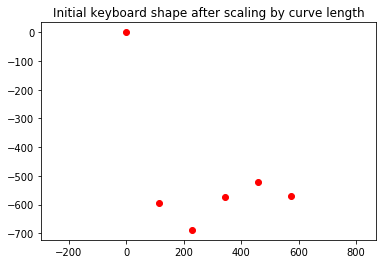

In [81]:

tck2 = interpolate.splrep(inpl_x, state2, s = 0)
spline2 = optimizer.formScaledSplineFromControlPoints(state2)
scale_factor = inpl_w / optimizer.findFunctionCurveLength(inpl_w, tck)[0]
print(scale_factor)
curved_pos_char_dict = optimizer.flatToCurved(spline)
total_dist = optimizer.calculateMovement(curved_pos_char_dict)
print(total_dist)
xnew = np.linspace(0, inpl_w * scale_factor, int(inpl_w))
ynew = interpolate.splev(xnew, spline2, der = 0)

plt.plot(inpl_x * scale_factor, interpolate.splev(inpl_x * scale_factor, tck2, der = 0),'ro')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

array([  0., 192., 384., 576., 768., 960.])

In [72]:
ynew

array([-1.59739213e-15,  5.88593042e-02,  1.21441047e-01,  1.87726225e-01,
        2.57695833e-01,  3.31330868e-01,  4.08612327e-01,  4.89521204e-01,
        5.74038497e-01,  6.62145201e-01,  7.53822313e-01,  8.49050828e-01,
        9.47811743e-01,  1.05008605e+00,  1.15585476e+00,  1.26509885e+00,
        1.37779932e+00,  1.49393717e+00,  1.61349340e+00,  1.73644901e+00,
        1.86278498e+00,  1.99248231e+00,  2.12552201e+00,  2.26188506e+00,
        2.40155247e+00,  2.54450522e+00,  2.69072432e+00,  2.84019076e+00,
        2.99288554e+00,  3.14878965e+00,  3.30788409e+00,  3.47014986e+00,
        3.63556794e+00,  3.80411935e+00,  3.97578507e+00,  4.15054610e+00,
        4.32838343e+00,  4.50927807e+00,  4.69321100e+00,  4.88016323e+00,
        5.07011575e+00,  5.26304956e+00,  5.45894564e+00,  5.65778501e+00,
        5.85954865e+00,  6.06421756e+00,  6.27177274e+00,  6.48219519e+00,
        6.69546589e+00,  6.91156584e+00,  7.13047605e+00,  7.35217751e+00,
        7.57665120e+00,  

In [82]:
state, dist = optimizer.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
  6839.11647    2445414.99     0.00%     0.00%     0:04:34     1:18:34

KeyboardInterrupt: 

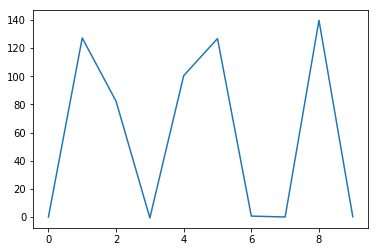

In [83]:
plt.plot(optimizer.state)

# Objective function: Fitt's law

Calculated curve_length: 977.5958369765613
Numerical error: 1.0853494069890793e-11
Scaled length:(960.0, 1.0658141036401503e-11)


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

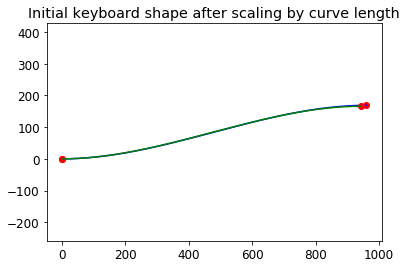

In [6]:
# Decide number of control points to define the curve (probably 1D curve first)
dof = 1
max_height = 200
# Since the keyboard is symmetric, we only need to define half of the keyboard.
inpl_h, inpl_w = 1080*3/4, 1920/2
# Use cubic spline with boundary conditions to fit the points (to get a smooth surface)
inpl_x = np.array(list(range(0, dof + 1))) / dof * inpl_w
inpl_y = np.random.rand(dof + 1) * max_height
inpl_y[0] = 0

# Interpolate with cubic spline
cs = interpolate.CubicSpline(inpl_x, inpl_y, bc_type = "clamped")
xnew = np.linspace(0, inpl_w, int(inpl_w) * 3)
ynew = cs(xnew)

plt.plot(inpl_x, inpl_y, 'ro', xnew, ynew, 'b') 
plt.axis('equal')
plt.title("Initial keyboard shape without scaling")
# Find length of spline by numerical integration
# Normalize movement in x direction by curve length to ensure the final lengh
length_integral = lambda x, cs: np.sqrt(1 + cs.derivative()(x) ** 2)
curve_integral = lambda x: length_integral(x, cs)
find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
total_curve_length, error = find_curve_length(inpl_w)
print("Calculated curve_length: {}".format(total_curve_length))
print("Numerical error: {}".format(error))

scale_factor = inpl_w/total_curve_length
scaled_cs = interpolate.CubicSpline(inpl_x * scale_factor, inpl_y * scale_factor, bc_type = "clamped")
scaled_xnew = xnew * scale_factor
scaled_ynew = scaled_cs(scaled_xnew)
scaled_curve_integral  = lambda x: length_integral(x, scaled_cs)
scaled_curve_length = lambda x: scipy.integrate.quad(scaled_curve_integral, 0, x)
print("Scaled length:{}".format(scaled_curve_length(inpl_w * scale_factor)))
plt.plot(inpl_x * scale_factor, inpl_y * scale_factor, 'ro', scaled_xnew, scaled_ynew, 'g-')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

# Option 1. constraint the total length to be 1920 or Option 2 only constrain the coordinates of points
# project points back onto the curve
# for option 1. project onto curve using length
# optimize the height of the points to reduce the movement of the thumbs

In [186]:
# Define optimization problem to be solved

class FittsLawOptimization3DShape(Annealer):
    
    def move(self):
        movement = np.random.randint(-1,1,len(self.state))
        movement[0] = 0
        self.state = self.state + movement
        #print("State: {}".format(self.state))
        
    def energy(self):
        
        penalty = 0
        if len([num for num in self.state if num < 0])!=0:
            penalty += 100000
        
        for ind, num in enumerate(self.state[:-1]):
            if self.state[ind + 1] < num:
                penalty += 1000 * abs(self.state[ind + 1] - num)
            
        
        spline = self.formScaledSplineFromControlPoints(self.state)
        curved_pos_char_dict = self.flatToCurved(spline)
        total_dist = self.calculateMovement(curved_pos_char_dict)
        
        #print("Spline: {}".format(spline))
        #print("New loc: {}".format(curved_pos_char_dict["d"]))
        #print("Distance: {}".format(total_dist))
        return total_dist + penalty
    
    def findFunctionCurveLength(self,x,cs):
        curve_integral = lambda x: np.sqrt(1 + cs.derivative()(x) ** 2)
        find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
        return find_curve_length(x)
    
    def formScaledSplineFromControlPoints(self,cp):
        # Interpolate with B-spline
        #print("CP: {}".format(cp))
        cs = interpolate.CubicSpline(inpl_x, cp, bc_type = "clamped")
        total_curve_length, error = self.findFunctionCurveLength(inpl_w, cs)

        scale_factor = inpl_w/total_curve_length
        scaled_cs = interpolate.CubicSpline(inpl_x * scale_factor, cp * scale_factor, bc_type = "clamped")
        
        return scaled_cs
        
    def flatToCurved(self, spline):
        curved_char_pos_dict = {}
        for key in left_keys:
            flat_x, flat_y = char_pos_dict[key]
            pos_x_on_curved_keyboard = optimize.brentq(lambda x: self.findFunctionCurveLength(x, spline)[0] - flat_x, 0, inpl_w)

            new_location = np.array([pos_x_on_curved_keyboard, flat_y, spline(pos_x_on_curved_keyboard) ])
            curved_char_pos_dict[key] = new_location
        
        return curved_char_pos_dict
            
    def calculateMovement(self, curved_pos_char_dict):
        print(curved_pos_char_dict)
        return runSimulation(cleaned_passage, curved_pos_char_dict)

In [187]:
optimizer = FittsLawOptimization3DShape(np.array([0, 200]))
print(optimizer.energy())

{'c': array([739.51127401, 618.6       , 172.82930279]), 's': array([369.27121503, 387.075     ,  67.10220979]), 'f': array([745.20228556, 387.075     , 173.9967372 ]), 'q': array([ 95.14552114, 159.27272727,   5.6348146 ]), 'e': array([471.7282413 , 159.27272727,  98.66196546]), 'z': array([360.38877969, 618.6       ,  64.46148789]), 'w': array([271.63828332, 159.27272727,  39.73592227]), 'a': array([169.35059211, 387.075     ,  16.83954809]), 'x': array([562.21077287, 618.6       , 126.54052138]), 't': array([826.59461533, 159.27272727, 187.63545077]), 'r': array([651.73550267, 159.27272727, 151.96609741]), 'd': array([556.28746042, 387.075     , 124.75982518])}


KeyError: 'i'

# 24/1/2019 Use spline with constraints

Constraints:
1. Zero gradient boundary conditions 
2. Symmetry
3. Increasing function?

In [56]:
dof = 5
max_height = 200
# Since the keyboard is symmetric, we only need to define half of the keyboard.
inpl_h, inpl_w = 1080*3/4, 1920/2
# Use cubic spline to fit the points (to get a smooth surface) (fixing both end-points)
inpl_x = np.array(list(range(0, dof + 2))) / dof * inpl_w

initial_state = np.linspace(0,max_height, 5)
optimizer = OptimizedKeyboardProblem(initial_state)

iteration_count = 0

def energy(state): 
    global iteration_count
    iteration_count += 1
    extended_state = np.insert(state, [0, len(state)], [0, max_height])
    print(state, extended_state)
    spline = optimizer.formScaledSplineFromControlPoints(extended_state)
    curved_pos_char_dict = optimizer.flatToCurved(spline)
    total_dist = optimizer.calculateMovement(curved_pos_char_dict)
    if iteration_count % 100 == 0:
        print("Iteration: {}\tState: {}\tDist: {}".format(iteration_count, state, total_dist))
    return total_dist


In [57]:
iteration_count = 0
ans = scipy.optimize.minimize(energy, initial_state, method = "Nelder-Mead")

[  0.  50. 100. 150. 200.] [  0.   0.  50. 100. 150. 200. 200.]


TypeError: Lengths of the first three arguments (x,y,w) must be equal

In [24]:
print(inpl_x)
print(initial_state)

[   0.  192.  384.  576.  768.  960. 1152.]
[  0.  50. 100. 150. 200.]


Assumptions:
1. Keyboard separated into two sections and each hand is responsible for one section
2. The first control point is always fixed at zero. (Define the position of the keyboard, prevent it from floating around)
3. Keyboard only curved in one direction

atomic keyboard
maybe adding an energy term (how much the thumbs bent) to the objective function
read the paper and design an objective function
apply it to a 2D keyboard (maybe  2D fiss law)
3D go back to distance
linear controller 3D fizz law


# Find optimal partition of a planar keyboard

1. Assume the keyboard buttons are circular
2. Initial position same as the original keyboard layout

Objective function: 1D Fitt's law for two thumbs typing (time) + Spring penalty (deviate from the original relative position too much)

Parameters: Positions of the centroids (50 dof + one button is fixed) +  size of the buttons (radius)(?) (26 dof) 

Constraints: Distance from the closest neighbouring button must be smaller than the radius


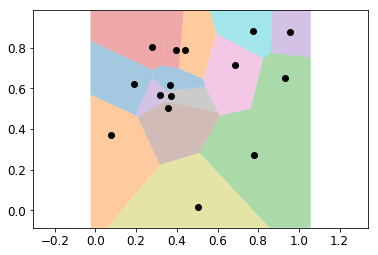

In [10]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1234)
points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[1] - 0.1
max_y = vor.max_bound[1] + 0.1

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)



box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voro.png')
plt.show()

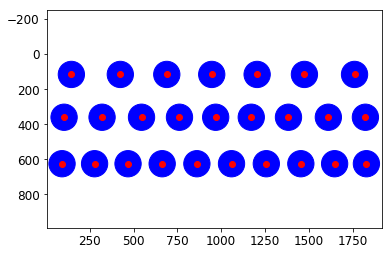

In [11]:
new_char_pos_dict = char_pos_dict.copy()
default_radius = 75
# Function for plotting the keyboard button positions
def plotKeyboardPositions(char_pos_dict):
    for char in char_pos_dict:
        plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], 'ro')
        circle1=plt.Circle(char_pos_dict[char],default_radius,color='b')
        plt.gcf().gca().add_artist(circle1)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()
        
plotKeyboardPositions(new_char_pos_dict)

In [29]:
# 1D Fitts Law
def fittsLaw1D(char1, char2,regions, vertices, boundary, char_pos_dict):
    
    # Using parameters from Zhai, et al.
    a, b = 0, 1/4.9
    a_same, b_same = 0.127, 0
    
    if char1 == char2:
        mt = a_same
    else:
        D, W = calculateFittsAW(char1,char2, regions, vertices, boundary, char_pos_dict)
        mt = a + b * np.log2(D / W + 1)
    
    return mt

# Calculate the mean time for the user to type a character (weighted Fitt's law from Metropolis keyboard)
def runSimulationSimple(digraph, char_pos_dict, boundary):
    regions, vertices = voronoiPartition(np.array([char_pos_dict[chr(ord('a') + ind)] for ind in range(26)]))
    
    fitts_dict = {}
    for ind1 in range(26):
        for ind2 in range(26):
            char1, char2 = chr(ord('a') + ind1), chr(ord('a') + ind2)
            fitts_dict[(char1,char2)] = fittsLaw1D(char1, char2, regions, vertices, boundary, char_pos_dict)
    
    return sum([fitts_dict[pair] * digraph[pair] for pair in digraph])
    

# Calculate the time for the user to type a document with two thumbs
def runSimulationTwoThumbs(document, char_pos_dict, boundary):

    regions, vertices = voronoiPartition(np.array([char_pos_dict[chr(ord('a') + ind)] for ind in range(26)]))
    
    fitts_dict = {}
    for ind1 in range(26):
        for ind2 in range(26):
            char1, char2 = chr(ord('a') + ind1), chr(ord('a') + ind2)
            fitts_dict[(char1,char2)] = fittsLaw1D(char1, char2, regions, vertices, boundary, char_pos_dict)
            
    total_time = 0
    
    # Rough estimate of t_min by comparing this to a_same = 0.127
    t_min = 0.1
    # Initialize left and right thumbs at the mean positions
    prev_char_left, prev_char_right = None, None
    prev_left_time, prev_right_time = 0, 0
    prev_thumb = None
    for char in document:
        if char_section_dict[char] == prev_thumb:
            if prev_thumb == Sections.LEFT:
                total_time += fitts_dict[(prev_char_left, char)]
                prev_left_time = total_time
                prev_char_left = char
            
            else:
                total_time += fitts_dict[(prev_char_right, char)]
                prev_right_time = total_time
                prev_char_right = char
                
        else:
            # Alternating typing
            if char_section_dict[char] == Sections.RIGHT:
                if prev_char_right == None:
                    prev_char_right = char
                    prev_right_time = total_time
                    prev_thumb = Sections.RIGHT
                else:
                    total_time = max(total_time + t_min, prev_right_time + fitts_dict[(prev_char_right, char)])
                    prev_right_time = total_time
                    prev_char_right = char
                    prev_thumb = Sections.RIGHT
            else:
                if prev_char_left == None:
                    prev_char_left = char
                    prev_left_time = total_time
                    prev_thumb = Sections.LEFT
                else:
                    total_time = max(total_time + t_min, prev_left_time + fitts_dict[(prev_char_left, char)])
                    prev_left_time = total_time
                    prev_char_left = char
                    prev_thumb = Sections.RIGHT
                
    return total_time

def generateDistanceDictionary(char_pos_dict):
    dist_dict = {}
    for ind1 in range(25):
        char1 = chr(ind1 + ord('a'))
        for ind2 in range(ind1 + 1, 26):
            char2 = chr(ind2 + ord('a'))
            dist_dict[(char1,char2)] = np.linalg.norm(char_pos_dict[char1] - char_pos_dict[char2])
            
    return dist_dict

initial_dist_dict = generateDistanceDictionary(char_pos_dict)

# Penalty for buttons changing positions relative to each other
def distancePenalty(char_pos_dict, initial_dist_dict):
    new_dist_dict = generateDistanceDictionary(char_pos_dict)
    
    penalty = 0
    
    for pair in new_dist_dict:
        penalty += abs(new_dist_dict[pair] - initial_dist_dict[pair])
        
    return penalty

def documentToDigraph(document):
    digraph = collections.defaultdict(int)
    
    for ind in range(len(document) - 1):
        digraph[(document[ind], document[ind+1])] += 1
        
    return digraph

In [9]:
iteration_count = 0
current_best = None
def objectiveFunction(state):
    global iteration_count, current_best
    char_pos_dict = {chr(ind + ord('a')) : np.array([state[2 * ind], state[2*ind + 1]]) for ind in range(26)}
    time, penalty = runSimulation(cleaned_passage, char_pos_dict), distancePenalty(char_pos_dict, 2 *default_radius)
    
    if iteration_count % 100 == 0:
        plotKeyboardPositions(char_pos_dict)
        print("Iterations : {}, Time : {}, Penalty : {}".format(iteration_count, time, penalty))
        
    iteration_count += 1
    current_best = state
    return time + penalty

In [35]:
# Two thumbs model should be faster than the simple model
boundary = LinearRing([[0,0],[1920,0],[1920, 1080 * 3/4], [0,1080 * 3 /4]])
print(runSimulationSimple(documentToDigraph(cleaned_passage), char_pos_dict, boundary))
print(runSimulationTwoThumbs(cleaned_passage, char_pos_dict, boundary))

4644.531314913775
2681.6195732493807


# 4/2/2019 
Questions:

Optimal partition of 2D keyboard by Fitts law
1. Objective function for two thumbs typing (but how to quantify width in Fitts law) + penalty for arrangement (how?)
2. Parameters: positions (attempted), could try to do rectangular shape but how to define general partition
3. Constraint: Shape? Should I constrain the shape?
4. Algorithm: SA? Something else?

a,b fitt's law 
spring stiffness different for each bi gram
baseline vs fitts law for two thumbs typing
W is the stopping distance D
Optimal shape for 3D keyboard
1. Objective function for two thumbs typing (width?)
2. Parameters:
3. Constraint:
4. Algorithm?

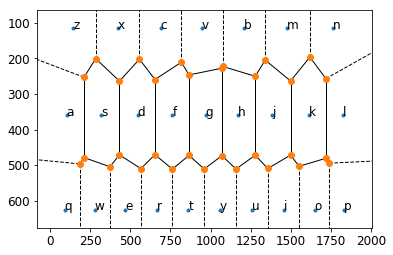

In [23]:
from scipy.spatial import Voronoi, voronoi_plot_2d
positions_order_sorted = np.array([char_pos_dict[chr(ind + ord('a'))] for ind in range(26)])


def plotKeyboardPartition(positions):
    vor = Voronoi(positions)
    voronoi_plot_2d(vor)
    
    for ind in range(26):
        plt.text(positions[ind][0], positions[ind][1], chr(ord('a') + ind))
    plt.gca().invert_yaxis()
    plt.show()
    
plotKeyboardPartition(positions_order_sorted)

In [14]:
line1 = LineString([(0,0),(1,0)])
line2 = LineString([(0,0.5), (0.5,0)])

ans = line1.intersection(line2)

print(ans)

POINT (0.5 0)


In [32]:
def voronoiPartition(positions):
    vor = Voronoi(positions)
    return voronoi_finite_polygons_2d(vor,1500)

def calculateFittsAW(char1, char2, regions, vertices, boundary, char_pos_dict):
    movement_vector = LineString([char_pos_dict[char1], char_pos_dict[char1]  + 10 * (char_pos_dict[char2] - char_pos_dict[char1])])

    intersection_points = []
    
    target_region = regions[ord(char2) - ord('a')]
    region_ring = LinearRing([vertices[vertex_ind] for vertex_ind in target_region])
    intersection = region_ring.intersection(movement_vector)
    if type(intersection) == Point:
        intersection_points.append(np.array(intersection))
    
    elif type(intersection) == MultiPoint:
        intersection_points.extend(np.array(intersection))        
    
    intersection = boundary.intersection(movement_vector)
    if type(intersection) == Point:
        intersection_points.append(np.array(intersection))
    
    elif type(intersection) == MultiPoint:
        intersection_points.extend(np.array(intersection))

    #plotGeometry(region_ring)
    #plotGeometry(boundary)
    #plotGeometry(movement_vector)
    #plt.show()
    intersection_points.sort(key = lambda point: np.linalg.norm(point - char_pos_dict[char1]))
    A = np.linalg.norm(intersection_points[0] - char_pos_dict[char1])
    W = np.linalg.norm(intersection_points[1] - intersection_points[0])
    

    
    return A, W

def plotGeometry(obj):
    x, y = obj.xy
    plt.plot(x,y)
    
#new_regions, new_vertices = voronoi_finite_polygons_2d(vor, 1500)

boundary = LinearRing([[0,0],[1920,0],[1920, 1080 * 3/4], [0,1080 * 3 /4]])

#for char1, char2 in initial_dist_dict:
#    print(char1, char2,calculateFittsAW(char1,char2, new_regions, new_vertices, boundary, char_pos_dict))


In [44]:
# Objective function taken from "Performance Optimization of Virtual Keyboards"

class OptimalPartitionSimple(Annealer):

    def __init__(self, state, boundary):
        self.boundary = boundary
        self.iteration = 0
        super(OptimalPartitionSimple, self).__init__(state)
        self.initial_dict = self.stateToDict()
        self.initial_dist_dict = generateDistanceDictionary(self.stateToDict())
        self.digraph = documentToDigraph(cleaned_passage)
        
    def move(self):
        update = np.random.uniform(-5, 5, 2)
        chosen_element = np.random.randint(0,26)
        self.state[chosen_element] += update
    
    def display(self, total_time, penalty):
        print("Iteration:{}\tMT:{}\tPenalty:{}\tTotal:{}".format(self.iteration, total_time, penalty, total_time + penalty))
        plotKeyboardPartition(self.state)
        
    def energy(self):
        
        total_time = runSimulationSimple(self.digraph, self.stateToDict(), self.boundary)
        stiffness = 0.001
        penalty = distancePenalty(self.stateToDict(), self.initial_dist_dict) * stiffness
        
        if self.iteration % 100 == 0:
            self.display(total_time, penalty)
            
        self.iteration += 1
        
        return total_time + penalty
    
    def stateToDict(self):
        return {chr(ord('a') + ind): self.state[ind] for ind in range(26)}
    

In [20]:
# Objective function taken from "Improving Two-Thumb Text Entry  on Touchscreen Devices"
class OptimalPartitionTwoThumbs(Annealer):
    def __init__(self, state, boundary):
        self.boundary = boundary
        self.iteration = 0
        super(OptimalPartitionTwoThumbs, self).__init__(state)
        self.initial_dict = self.stateToDict()
        self.initial_dist_dict = generateDistanceDictionary(self.stateToDict())
    def move(self):
        update = np.random.uniform(-5, 5, (26, 2))
        #update[6] = np.array([0,0])
        self.state += update
        
    def display(self, total_time, penalty):
        print("Iteration:{}\tMT:{}\tPenalty:{}\tTotal:{}".format(self.iteration, total_time, penalty, total_time + penalty))
        plotKeyboardPositions(self.stateToDict())
        
    def energy(self):
        
        total_time = runSimulationTwoThumbs(cleaned_passage, self.stateToDict(), self.boundary)
        stiffness = 0.001
        penalty = distancePenalty(self.stateToDict(), self.initial_dist_dict) * stiffness
        
        if self.iteration % 100 == 0:
            self.display(total_time, penalty)
            
        self.iteration += 1
        
        return total_time + penalty
    
    def stateToDict(self):
        return {chr(ord('a') + ind): self.state[ind] for ind in range(26)}
        
    
        

Iteration:0	MT:4620.0488933929155	Penalty:0.0	Total:4620.0488933929155


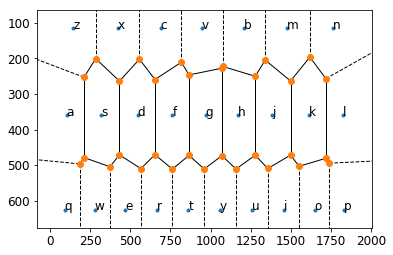

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    27.18853       4620.18   100.00%     0.00%     0:00:19     0:07:46

Iteration:100	MT:4619.184732405876	Penalty:0.3674401254031139	Total:4619.552172531279


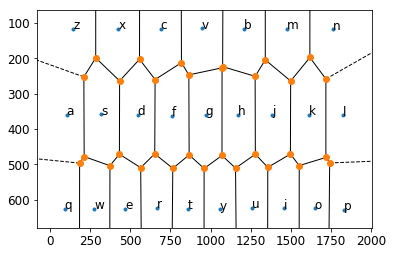

    24.61605       4622.02   100.00%   100.00%     0:00:39     0:07:32

Iteration:200	MT:4621.6931133509115	Penalty:0.49185950544225726	Total:4622.184972856354


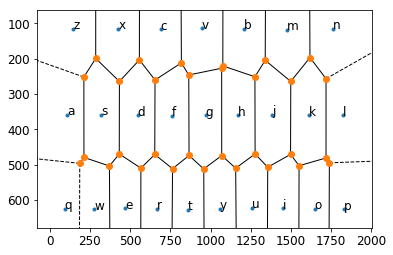

    22.28698       4621.25   100.00%   100.00%     0:00:59     0:07:14

Iteration:300	MT:4620.23061173649	Penalty:0.6331499532487185	Total:4620.863761689739


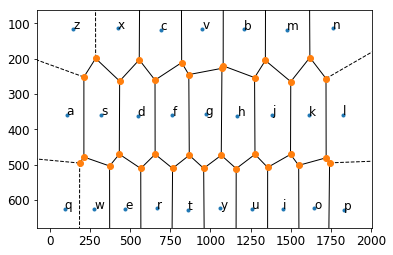

    20.17827       4622.00   100.00%     0.00%     0:01:19     0:06:56

Iteration:400	MT:4621.414584277648	Penalty:0.7732148392484377	Total:4622.187799116897


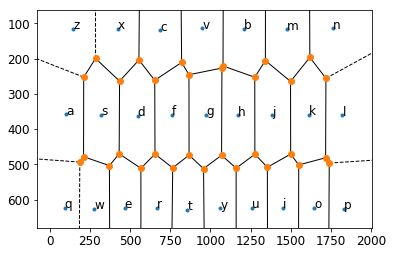

    18.26908       4625.14   100.00%     0.00%     0:01:39     0:06:37

Iteration:500	MT:4624.381963407889	Penalty:0.9840258274669307	Total:4625.365989235356


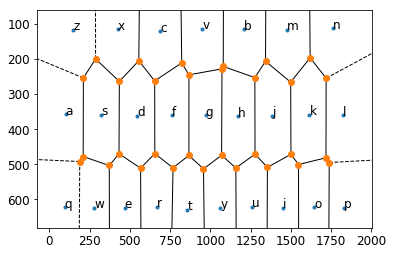

    16.54053       4623.13   100.00%     0.00%     0:02:00     0:06:20

Iteration:600	MT:4621.7073319111905	Penalty:1.1528981406155712	Total:4622.860230051806


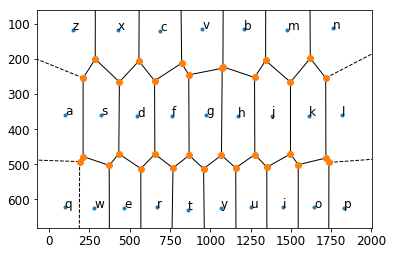

    14.97553       4618.47   100.00%   100.00%     0:02:20     0:06:01

Iteration:700	MT:4617.379298065162	Penalty:1.3167131304852104	Total:4618.696011195648


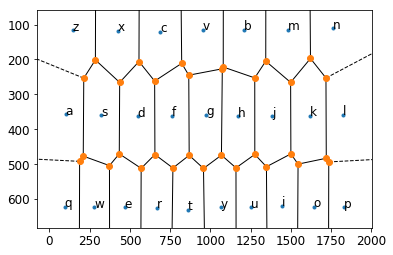

    13.55860       4620.06   100.00%     0.00%     0:02:40     0:05:41

Iteration:800	MT:4618.764615450889	Penalty:1.3143808130738834	Total:4620.078996263963


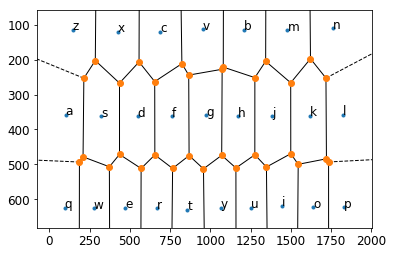

    12.27574       4621.33   100.00%     0.00%     0:03:00     0:05:21

Iteration:900	MT:4620.102116270443	Penalty:1.2982116341711984	Total:4621.400327904614


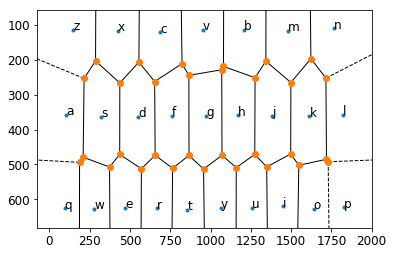

    11.11426       4624.72   100.00%     0.00%     0:03:20     0:05:01

Iteration:1000	MT:4623.291764773279	Penalty:1.4090695980445471	Total:4624.700834371324


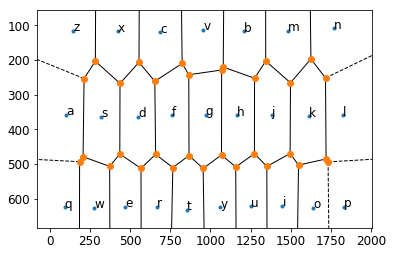

    10.06267       4627.42   100.00%     0.00%     0:03:40     0:04:41

Iteration:1100	MT:4626.0360847532975	Penalty:1.4073852628654187	Total:4627.443470016163


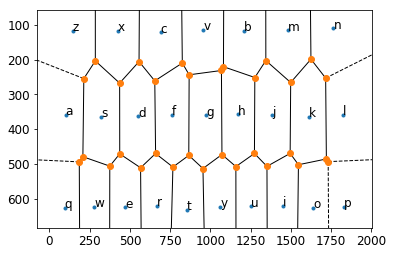

     9.11058       4625.48   100.00%     0.00%     0:04:01     0:04:21

Iteration:1200	MT:4624.102928725234	Penalty:1.356490632624537	Total:4625.459419357859


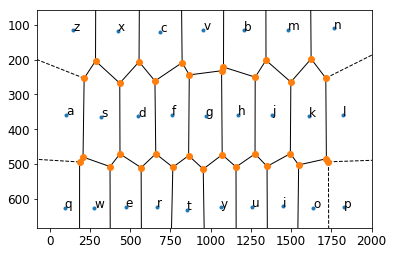

     8.24857       4626.15   100.00%   100.00%     0:04:20     0:04:01

Iteration:1300	MT:4624.291528216735	Penalty:1.4259023456562803	Total:4625.717430562391


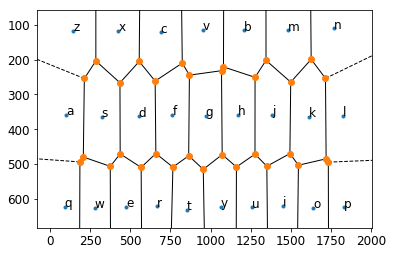

     7.46812       4627.51   100.00%     0.00%     0:04:41     0:03:41

Iteration:1400	MT:4626.239562605657	Penalty:1.4785742941603748	Total:4627.718136899817


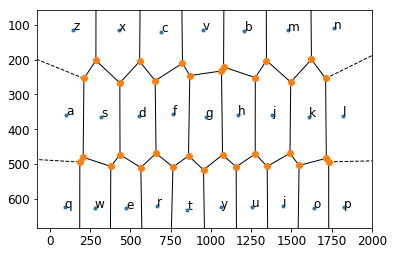

     6.76152       4626.53   100.00%   100.00%     0:05:00     0:03:21

Iteration:1500	MT:4625.060860561243	Penalty:1.542169392905216	Total:4626.603029954149


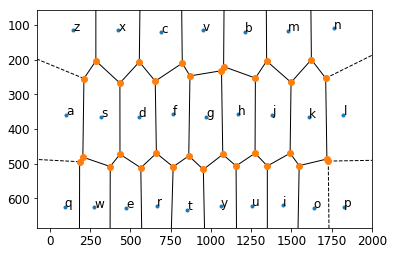

     6.12177       4626.65   100.00%     0.00%     0:05:20     0:03:00

Iteration:1600	MT:4625.070489731961	Penalty:1.5781527651082512	Total:4626.648642497069


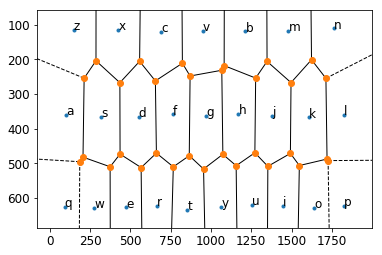

     5.54255       4629.45   100.00%   100.00%     0:05:40     0:02:40

Iteration:1700	MT:4627.755598096031	Penalty:1.7435864225992475	Total:4629.49918451863


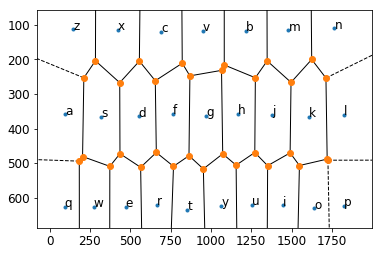

     5.01814       4628.78   100.00%   100.00%     0:06:01     0:02:21

Iteration:1800	MT:4627.067411176625	Penalty:1.681496008673078	Total:4628.748907185298


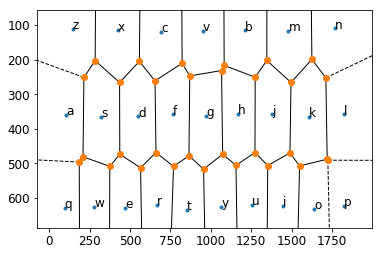

     4.54334       4626.36   100.00%     0.00%     0:06:21     0:02:00

Iteration:1900	MT:4624.45858043999	Penalty:1.7713586233601395	Total:4626.229939063351


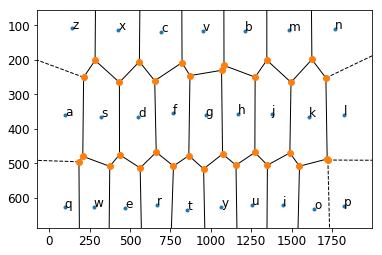

     4.11347       4625.29   100.00%   100.00%     0:06:41     0:01:41

Iteration:2000	MT:4623.928710379089	Penalty:1.9600045740717644	Total:4625.888714953161


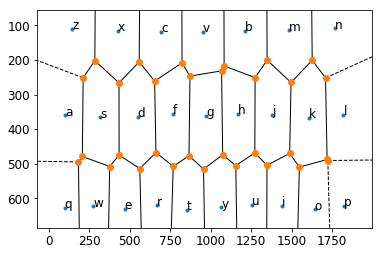

     3.72427       4628.48   100.00%   100.00%     0:07:02     0:01:21

Iteration:2100	MT:4626.437617585725	Penalty:2.0815095484234427	Total:4628.519127134148


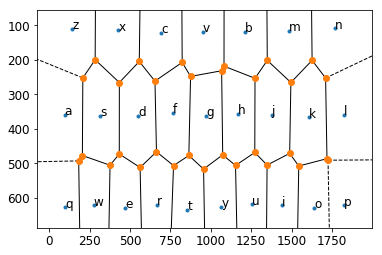

     3.37189       4630.84   100.00%   100.00%     0:07:22     0:01:01

Iteration:2200	MT:4628.737936690526	Penalty:2.1273784791469295	Total:4630.865315169673


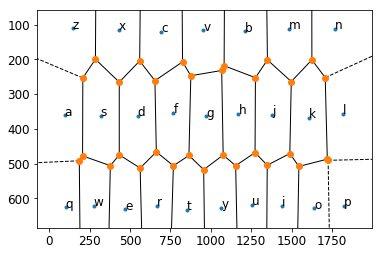

     3.27934       4631.33   100.00%     0.00%     0:07:28     0:00:55

(array([[  94.92619545,  361.54123743],
        [1213.28652955,  119.14154778],
        [ 693.58824227,  120.22771474],
        [ 548.32574948,  362.68759802],
        [ 468.30432126,  631.87133335],
        [ 767.97702262,  354.41852529],
        [ 972.93620351,  364.3954204 ],
        [1170.99786667,  356.78496588],
        [1441.47485313,  621.81439567],
        [1379.29020733,  358.6277825 ],
        [1609.29741474,  368.96028495],
        [1820.57317106,  357.68749505],
        [1483.99279641,  111.4455672 ],
        [1767.89259121,  111.39307494],
        [1639.55692938,  628.79700283],
        [1823.16573   ,  622.2258727 ],
        [  99.5164104 ,  627.26499296],
        [ 667.11800903,  620.17565505],
        [ 317.28141476,  362.77680119],
        [ 852.49852598,  633.50187904],
        [1253.36773724,  618.39082361],
        [ 952.35333096,  116.38977798],
        [ 275.13437237,  622.66304062],
        [ 428.32558238,  114.79048653],
        [1064.96728451,  627.01522466],


In [45]:
# Simulated Annealing for simple model
initial_state = np.array([char_pos_dict[chr(ord('a') + ind)] for ind in range(26)])
boundary = LinearRing([[0,0],[1920,0],[1920, 1080], [0,1080]])

optimalPartitionSimple = OptimalPartitionSimple(initial_state, boundary)
optimalPartitionSimple.copy_strategy = "slice"
optimalPartitionSimple.updates = 10000
optimalPartitionSimple.Tmax = 30
optimalPartitionSimple.steps = 2500
optimalPartitionSimple.anneal()

Iteration:0	MT:1283.6130950650358	Penalty:0.0	Total:1283.6130950650358


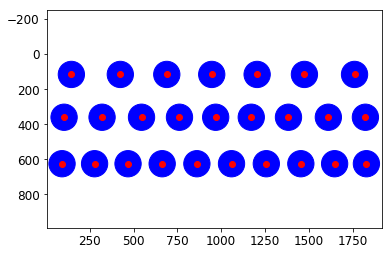

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    27.18853       1345.23   100.00%   100.00%     0:00:20     0:08:17

Iteration:100	MT:1333.6264679484598	Penalty:10.309783864636339	Total:1343.936251813096


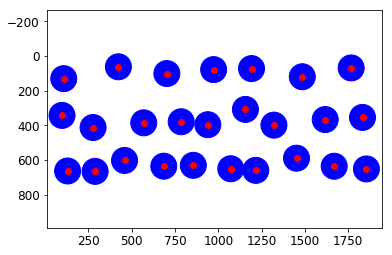

    24.61605       1317.67   100.00%     0.00%     0:00:41     0:07:54

Iteration:200	MT:1311.344168552583	Penalty:13.453007841401984	Total:1324.797176393985


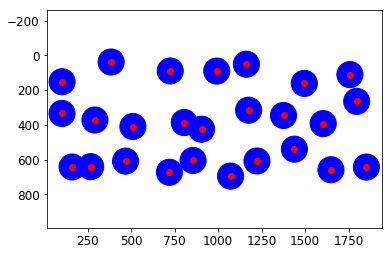

    22.28698       1247.14   100.00%   100.00%     0:01:03     0:07:46

Iteration:300	MT:1232.0297763662015	Penalty:16.791749213718116	Total:1248.8215255799196


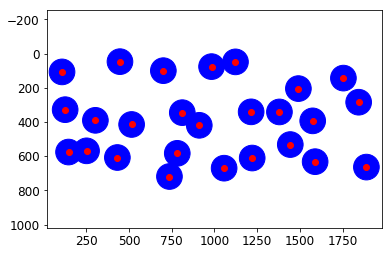

    20.17827       1240.87   100.00%   100.00%     0:01:25     0:07:27

Iteration:400	MT:1224.2251923154263	Penalty:19.461762974834258	Total:1243.6869552902606


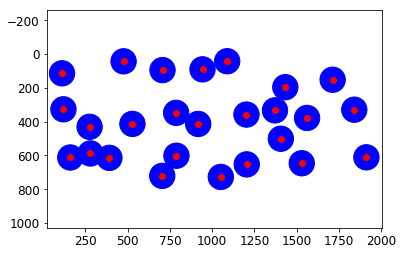

    18.26908       1248.37   100.00%     0.00%     0:01:47     0:07:08

Iteration:500	MT:1230.2052753149678	Penalty:21.783030035602092	Total:1251.9883053505698


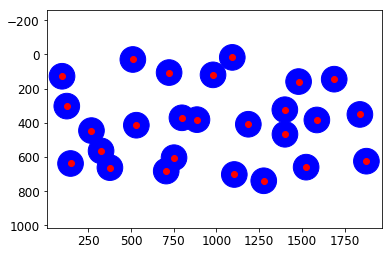

    16.54053       1318.52   100.00%   100.00%     0:02:08     0:06:46

Iteration:600	MT:1293.1605346265073	Penalty:22.55597716258939	Total:1315.7165117890968


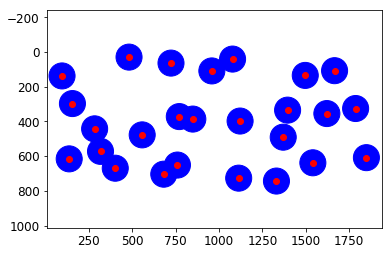

    14.97553       1365.24   100.00%   100.00%     0:02:29     0:06:25

Iteration:700	MT:1335.7888883060466	Penalty:25.245888215811377	Total:1361.034776521858


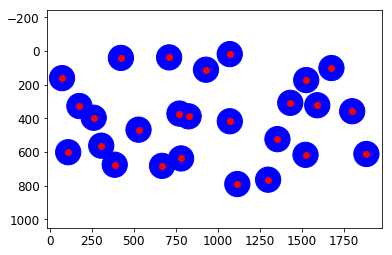

    13.76227       1413.95   100.00%     0.00%     0:02:48     0:06:08

IndexError: list index out of range

In [129]:
initial_state = np.array([char_pos_dict[chr(ord('a') + ind)] for ind in range(26)])
boundary = LinearRing([[-500,-500],[-500,2500],[2500, 2500], [2500,-500]])

optimalPartition = OptimalPartitionTwoThumbs(initial_state, boundary)
optimalPartition.copy_strategy = "slice"
optimalPartition.updates = 10000
optimalPartition.Tmax = 30
optimalPartition.steps = 2500
optimalPartition.anneal()

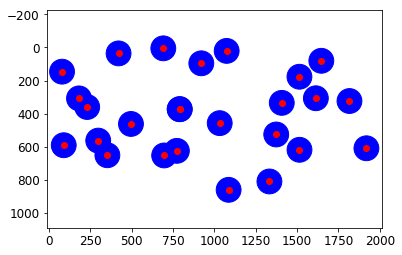

[[ 181.02159919  307.81368745]
 [1073.89904478   20.64753575]
 [ 690.81915102    5.15677259]
 [ 495.2982287   462.42472095]
 [ 352.66312322  651.68000061]
 [ 789.87755539  372.83454633]
 [ 790.06367973  373.4521859 ]
 [1031.89547881  457.53067091]
 [1373.57854897  526.02693955]
 [1407.07211512  334.90169808]
 [1613.21246229  307.00687442]
 [1816.47996612  323.77893159]
 [1513.94613933  176.93716029]
 [1646.32600819   80.51574297]
 [1514.31015098  618.69777243]
 [1918.87834941  609.42737672]
 [  88.79489119  591.03955268]
 [ 695.94365644  652.83755045]
 [ 230.55672745  360.03384477]
 [ 772.9356909   624.99526174]
 [1332.44486435  810.19406623]
 [ 920.59840333   95.68733737]
 [ 297.27135395  563.09909509]
 [ 420.32753727   35.79106582]
 [1085.76642024  860.76763771]
 [  78.53183957  146.23953206]] 1221.4458128982853


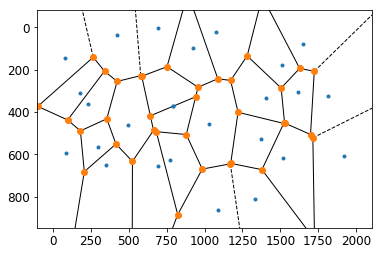

In [136]:
plotKeyboardPositions(optimalPartition.stateToDict())

print(optimalPartition.best_state, optimalPartition.best_energy)
plotKeyboardPartition(optimalPartition.best_state)

# Find Fitts Law Empirical Constants

In [61]:
import os
from datetime import datetime

cwd = os.getcwd()
data_path = "{}\FittsLawEmpiricalData".format(cwd)

directory = os.fsencode(data_path)

timedelta_dict = {}
data = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with open("{}\{}".format(data_path, filename), 'r') as f:
        release_time, press_time = [], []
        char1, char2 = filename.split(".")[0]
        A, W = calculateFittsAW(char1, char2, new_regions, new_vertices, boundary, char_pos_dict)
        ID = np.log2(A/W + 1)
        for ind, line in enumerate(f):
            if ind == 0:
                continue
            else:
                data_array = line.split("\t")
                datetime_object = datetime.strptime(data_array[0], "%Y-%m-%d-%H-%M-%S-%f")
                if ind % 2 == 0:
                    press_time.append(datetime_object)
                else:
                    release_time.append(datetime_object)
        mean_time = np.mean(np.array([(press - release).total_seconds()for press, release in zip(press_time, release_time)]))
        data.append([ID, mean_time])
        
data = np.array(data)
        
    

In [67]:
char1, char2 = "a", "s"
print(calculateFittsAW(char1,char2,new_regions, new_vertices, boundary, char_pos_dict))
print(calculateFittsAW(char2,char1,new_regions, new_vertices, boundary, char_pos_dict))
print(char_pos_dict["v"])

(108.32610000000003, 220.84734999999995)
(108.3261, 212.04770000000002)
[945.9147 116.0125]


In [70]:
data.shape

(11, 2)

In [63]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(data[:,0].reshape(-1,1), data[:,1])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [64]:
reg.score(data[:,0].reshape(-1,1), data[:,1])

0.49384789820058805

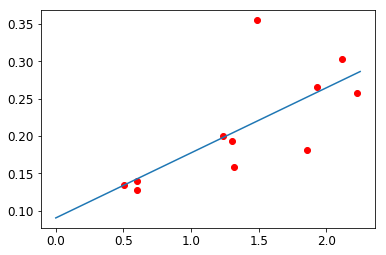

In [67]:
plt.plot(data[:,0], data[:,1] ,'ro')
X_test = np.linspace(0,2.25, 100).reshape(-1,1)
plt.plot(X_test, model.predict(X_test))

In [68]:
model.coef_,model.intercept_

(array([0.08710074]), 0.09028730436916985)

array([0.        , 0.02272727, 0.04545455, 0.06818182, 0.09090909,
       0.11363636, 0.13636364, 0.15909091, 0.18181818, 0.20454545,
       0.22727273, 0.25      , 0.27272727, 0.29545455, 0.31818182,
       0.34090909, 0.36363636, 0.38636364, 0.40909091, 0.43181818,
       0.45454545, 0.47727273, 0.5       , 0.52272727, 0.54545455,
       0.56818182, 0.59090909, 0.61363636, 0.63636364, 0.65909091,
       0.68181818, 0.70454545, 0.72727273, 0.75      , 0.77272727,
       0.79545455, 0.81818182, 0.84090909, 0.86363636, 0.88636364,
       0.90909091, 0.93181818, 0.95454545, 0.97727273, 1.        ,
       1.02272727, 1.04545455, 1.06818182, 1.09090909, 1.11363636,
       1.13636364, 1.15909091, 1.18181818, 1.20454545, 1.22727273,
       1.25      , 1.27272727, 1.29545455, 1.31818182, 1.34090909,
       1.36363636, 1.38636364, 1.40909091, 1.43181818, 1.45454545,
       1.47727273, 1.5       , 1.52272727, 1.54545455, 1.56818182,
       1.59090909, 1.61363636, 1.63636364, 1.65909091, 1.68181

In [69]:
np.log2(879/110+1)

3.1684669972344515